In [1]:
import pymysql
import pymysql.cursors
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
#connect my database

In [3]:
mydb = pymysql.connect(
    host='127.0.0.1',
    port=3306,
    user='root',
    passwd='',
    db='action'
    )

In [4]:
#merge table information

In [ ]:
cursor=mydb.cursor()
all_info_table_train='CREATE TABLE all_info_table_train AS\
                SELECT P.cate,A.user_id,A.sku_id,A.action_time,P.brand,P.shop_id,A.type,U.sex,U.age,U.user_lv_cd,U.city_level\
                FROM action AS A\
                JOIN product AS P ON P.sku_id=A.sku_id\
                JOIN user AS U ON U.user_id=A.user_id\
                WHERE A.type=2 AND A.action_time BETWEEN "2018-02-01 00:00:00" AND "2018-04-10 00:00:00"'
cursor.execute(all_info_table_train)
myresult_train=cursor.fetchall()

In [ ]:
cursor2=mydb.cursor()
all_info_table_test='CREATE TABLE all_info_table_test AS\
                SELECT P.cate,A.user_id,A.sku_id,A.action_time,P.brand,P.shop_id,A.type,U.sex,U.age,U.user_lv_cd,U.city_level\
                FROM action AS A\
                JOIN product AS P ON P.sku_id=A.sku_id\
                JOIN user AS U ON U.user_id=A.user_id\
                WHERE A.type=2 AND A.action_time BETWEEN "2018-04-10 00:00:00" AND "2018-04-16 00:00:00"'
cursor2.execute(all_info_table_test)
myresult_test=cursor.fetchall()

In [ ]:
cursor.close()

In [6]:
top10_all_info_table_train='SELECT *\
                            FROM all_info_table_train\
                            limit 10'
sql_top_10_all_info_table_train=pd.read_sql_query(top10_all_info_table_train,mydb)
print(sql_top_10_all_info_table_train)

   cate  user_id  sku_id            action_time  brand  shop_id  type  sex  \
0    79   660257  282037  2018-02-08 15:05:37.0   4854     5338     2  1.0   
1    79  1008776   31647  2018-03-02 01:02:08.0  10511     9665     2  0.0   
2    79  1569797  141162  2018-02-06 22:32:30.0   4854       79     2  1.0   
3    79  1066676  102904  2018-03-08 10:22:09.0   1226     7129     2  1.0   
4    79  1314628  102417  2018-02-05 11:47:45.0   5700     1553     2  1.0   
5    79   982912  264665  2018-02-18 16:19:44.0   1898     1182     2  0.0   
6    79   260858  307497  2018-02-01 19:29:26.0   5206     9665     2  0.0   
7    79  1123179  274889  2018-03-18 16:26:49.0   2564     6710     2  1.0   
8    79   148013   47151  2018-02-21 18:48:56.0   2564     1095     2  1.0   
9    79   399810  270064  2018-03-04 11:47:11.0   4361     5896     2  1.0   

   age  user_lv_cd city_level  
0  5.0           1             
1  6.0           7        4.0  
2  5.0           5        4.0  
3  6.0       

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score as AUC
from sklearn.metrics import mean_absolute_error
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from scipy import stats
from copy import deepcopy
import csv
import os

In [8]:
#load dataset

In [9]:
train_df=pd.read_csv('/Users/charles/Desktop/consumer/all_info_table_train.csv')
test_df=pd.read_csv('/Users/charles/Desktop/consumer/all_info_table_test.csv')

In [10]:
train_df.head(5)

cate  user_id  sku_id            action_time  brand  shop_id  type  sex  \
0    79   660257  282037  2018-02-08 15:05:37.0   4854     5338     2  1.0   
1    79  1008776   31647  2018-03-02 01:02:08.0  10511     9665     2  0.0   
2    79  1569797  141162  2018-02-06 22:32:30.0   4854       79     2  1.0   
3    79  1066676  102904  2018-03-08 10:22:09.0   1226     7129     2  1.0   
4    79  1314628  102417  2018-02-05 11:47:45.0   5700     1553     2  1.0   

   age  user_lv_cd  city_level  
0  5.0           1         NaN  
1  6.0           7         4.0  
2  5.0           5         4.0  
3  6.0           7         1.0  
4  5.0           5         1.0

In [11]:
test_df.head(5)

cate  user_id  sku_id            action_time  brand  shop_id  type  sex  \
0    79   537520   58984  2018-04-14 18:44:53.0   2564     1095     2  NaN   
1    19  1195693  261922  2018-04-14 17:48:01.0   7357     4059     2  1.0   
2    27  1074877  134144  2018-04-10 16:15:11.0   6588     3663     2  0.0   
3    79   158811  114345  2018-04-12 13:19:58.0   6574     4071     2  1.0   
4    72   852571  219951  2018-04-10 23:18:54.0   3746     7196     2 -1.0   

   age  user_lv_cd  city_level  
0  NaN           5         NaN  
1  5.0           1         NaN  
2  5.0           7         1.0  
3  5.0           5         1.0  
4  5.0           6         1.0

In [12]:
train_df.shape

(1978964, 11)

In [13]:
test_df.shape

(184682, 11)

In [14]:
train_df.describe()

cate       user_id        sku_id         brand       shop_id  \
count  1.978964e+06  1.978964e+06  1.978964e+06  1.978964e+06  1.978964e+06   
mean   4.021845e+01  8.038331e+05  1.903919e+05  5.080010e+03  5.171412e+03   
std    2.556868e+01  4.643364e+05  1.087221e+05  3.222402e+03  3.007510e+03   
min    1.000000e+00  1.000000e+00  1.300000e+01  1.000000e+00  1.000000e+00   
25%    2.000000e+01  4.018278e+05  9.748900e+04  2.484000e+03  2.491000e+03   
50%    3.400000e+01  8.035870e+05  1.889780e+05  4.491000e+03  5.172000e+03   
75%    6.900000e+01  1.206099e+06  2.856360e+05  7.954000e+03  7.831000e+03   
max    8.100000e+01  1.608707e+06  3.784560e+05  1.119900e+04  1.039900e+04   

            type           sex           age    user_lv_cd    city_level  
count  1978964.0  1.978066e+06  1.976863e+06  1.978964e+06  1.977190e+06  
mean         2.0  4.282981e-01  4.644960e+00  4.525498e+00  3.319738e+00  
std          0.0  5.065627e-01  1.467262e+00  2.379927e+00  1.416239e+00  
min          2.0 -1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00  
25%          2.0  0.000000e+00  4.000000e+00  1.000000e+00  3.000000e+00  
50%          2.0  0.000000e+00  5.000000e+00  5.000000e+00  4.000000e+00  
75%          2.0  1.000000e+00  6.000000e+00  6.000000e+00  4.000000e+00  
max          2.0  1.000000e+00  6.000000e+00  7.000000e+00  6.000000e+00

In [15]:
#find null value

In [16]:
pd.isnull(train_df).values.any()

True

In [17]:
#there is existing null vaule in train dataset

In [18]:
#clean null values

In [19]:
pd.isnull(train_df['cate']).values.any()

False

In [20]:
pd.isnull(train_df['user_id']).values.any()

False

In [21]:
pd.isnull(train_df['sku_id']).values.any()

False

In [22]:
pd.isnull(train_df['brand']).values.any()

False

In [23]:
pd.isnull(train_df['shop_id']).values.any()

False

In [24]:
pd.isnull(train_df['sex']).values.any()

True

Text(0, 0.5, 'count')

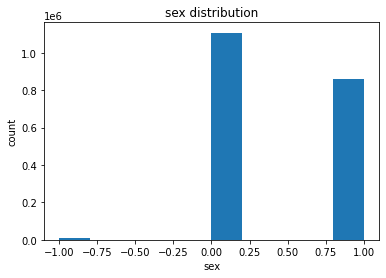

In [25]:
train_df['sex'].plot(kind='hist')
plt.title('sex distribution')
plt.xlabel('sex')
plt.ylabel('count')

In [26]:
pd.isnull(train_df['sex']).value_counts()

False    1978066
True         898
Name: sex, dtype: int64

In [27]:
#the number is small, we delete them directly

In [28]:
train_df.dropna(subset=['sex'],how='any',inplace=True)

In [29]:
pd.isnull(train_df['age']).value_counts()

False    1976863
True        1203
Name: age, dtype: int64

In [30]:
train_df.dropna(subset=['age'],how='any',inplace=True)

In [31]:
pd.isnull(train_df['user_lv_cd']).value_counts()

False    1976863
Name: user_lv_cd, dtype: int64

In [32]:
pd.isnull(train_df['city_level']).value_counts()

False    1975989
True         874
Name: city_level, dtype: int64

In [33]:
train_df.dropna(subset=['city_level'],how='any',inplace=True)

In [34]:
train_df.describe()

cate       user_id        sku_id         brand       shop_id  \
count  1.975989e+06  1.975989e+06  1.975989e+06  1.975989e+06  1.975989e+06   
mean   4.022768e+01  8.038508e+05  1.903757e+05  5.081174e+03  5.170531e+03   
std    2.556894e+01  4.643388e+05  1.087322e+05  3.222303e+03  3.007234e+03   
min    1.000000e+00  1.000000e+00  1.300000e+01  1.000000e+00  1.000000e+00   
25%    2.000000e+01  4.018390e+05  9.745500e+04  2.484000e+03  2.491000e+03   
50%    3.400000e+01  8.035930e+05  1.889230e+05  4.491000e+03  5.166000e+03   
75%    6.900000e+01  1.206128e+06  2.856360e+05  7.954000e+03  7.831000e+03   
max    8.100000e+01  1.608707e+06  3.784560e+05  1.119900e+04  1.039900e+04   

            type           sex           age    user_lv_cd    city_level  
count  1975989.0  1.975989e+06  1.975989e+06  1.975989e+06  1.975989e+06  
mean         2.0  4.291036e-01  4.645014e+00  4.524825e+00  3.319691e+00  
std          0.0  5.055324e-01  1.467270e+00  2.380551e+00  1.416086e+00  
min          2.0 -1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00  
25%          2.0  0.000000e+00  4.000000e+00  1.000000e+00  3.000000e+00  
50%          2.0  0.000000e+00  5.000000e+00  5.000000e+00  4.000000e+00  
75%          2.0  1.000000e+00  6.000000e+00  6.000000e+00  4.000000e+00  
max          2.0  1.000000e+00  6.000000e+00  7.000000e+00  6.000000e+00

In [35]:
train_df.shape

(1975989, 11)

In [36]:
#Outliers

In [37]:
#statistic each product id sale in train set

Text(0, 0.5, 'sales')

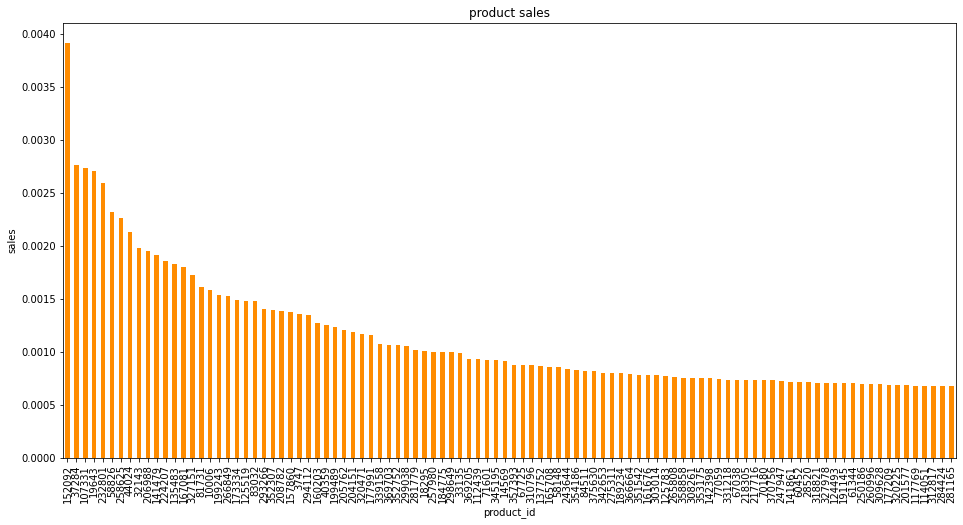

In [38]:
plt.figure(figsize=(16,8))
train_df['sku_id'].value_counts(normalize=True)[:100].plot(kind='bar',color='darkorange')
plt.title('product sales')
plt.xlabel('product_id')
plt.ylabel('sales')

In [39]:
train_df['sku_id'].value_counts(ascending=False)[:5]

152092    7724
37284     5457
107331    5407
19643     5341
232801    5126
Name: sku_id, dtype: int64

In [40]:
train_df[train_df['sku_id']==152092]

cate  user_id  sku_id            action_time  brand  shop_id  type  \
9610       69   161965  152092  2018-03-13 11:55:12.0   5277     4005     2   
9627       69     1092  152092  2018-03-29 17:08:11.0   5277     4005     2   
9659       69  1204522  152092  2018-02-06 09:09:21.0   5277     4005     2   
9661       69   333311  152092  2018-04-03 09:28:48.0   5277     4005     2   
9670       69   640484  152092  2018-02-11 07:39:09.0   5277     4005     2   
...       ...      ...     ...                    ...    ...      ...   ...   
1972808    69   257777  152092  2018-03-23 13:43:13.0   5277     4005     2   
1972846    69   508957  152092  2018-02-05 19:45:08.0   5277     4005     2   
1972878    69  1337253  152092  2018-03-26 23:43:00.0   5277     4005     2   
1972879    69  1022656  152092  2018-02-17 19:13:11.0   5277     4005     2   
1972885    69   462970  152092  2018-03-25 15:46:03.0   5277     4005     2   

         sex  age  user_lv_cd  city_level  
9610     1.0  5.0           5         5.0  
9627     0.0  6.0           6         4.0  
9659     0.0  5.0           5         4.0  
9661     0.0  5.0           1         4.0  
9670     0.0  6.0           6         4.0  
...      ...  ...         ...         ...  
1972808  1.0  6.0           6         1.0  
1972846  0.0  6.0           1         5.0  
1972878  0.0  2.0           1         5.0  
1972879  0.0  5.0           7         5.0  
1972885  0.0  5.0           1         4.0  

[7724 rows x 11 columns]

In [45]:
#change date form

In [46]:
train_df['action_time']=pd.to_datetime(train_df['action_time']).dt.strftime('%Y%m%d')
train_df['action_time']

1          20180302
2          20180206
3          20180308
4          20180205
5          20180218
             ...   
1978959    20180403
1978960    20180304
1978961    20180312
1978962    20180313
1978963    20180211
Name: action_time, Length: 1975989, dtype: object

In [47]:
train_df[train_df['sku_id']==152092].value_counts('action_time')

action_time
20180328    380
20180312    272
20180204    253
20180228    214
20180205    193
           ... 
20180218     37
20180217     35
20180214     31
20180216     22
20180215     20
Length: 68, dtype: int64

Text(0, 0.5, 'sales')

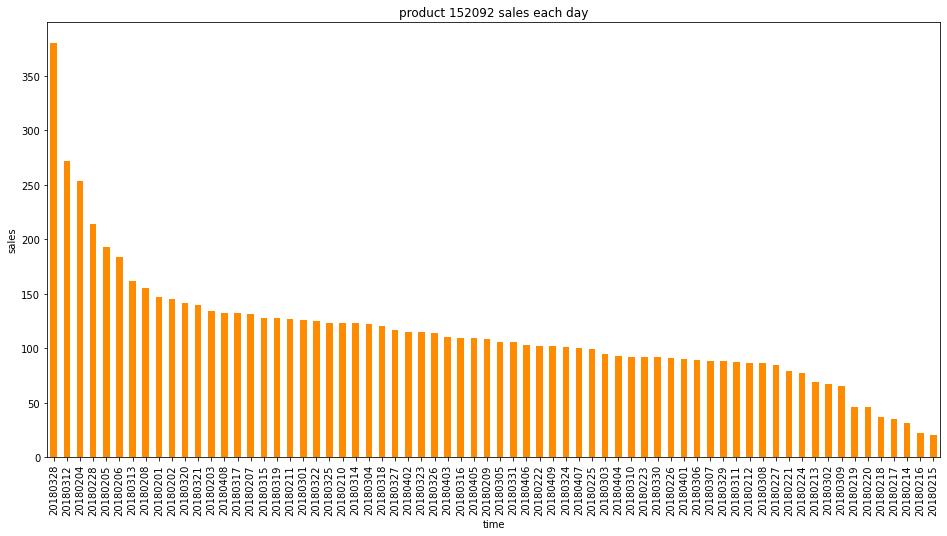

In [48]:
plt.figure(figsize=(16,8))
train_df[train_df['sku_id']==152092].value_counts('action_time').plot(kind='bar',color='darkorange')
plt.title('product 152092 sales each day')
plt.xlabel('time')
plt.ylabel('sales')

In [50]:
train_df['sku_id'].value_counts(ascending=True)[:10]

52710     1
351916    1
376496    1
368308    1
25092     1
29190     1
49680     1
53778     1
39451     1
66088     1
Name: sku_id, dtype: int64

In [41]:
#change action time to number representing

In [51]:
from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()
train_df['date_num'] = label_encoder.fit_transform(train_df['action_time'])

In [52]:
train_df

cate  user_id  sku_id action_time  brand  shop_id  type  sex  age  \
1          79  1008776   31647    20180302  10511     9665     2  0.0  6.0   
2          79  1569797  141162    20180206   4854       79     2  1.0  5.0   
3          79  1066676  102904    20180308   1226     7129     2  1.0  6.0   
4          79  1314628  102417    20180205   5700     1553     2  1.0  5.0   
5          79   982912  264665    20180218   1898     1182     2  0.0  5.0   
...       ...      ...     ...         ...    ...      ...   ...  ...  ...   
1978959     3   254643  126121    20180403   4854     5338     2  1.0  5.0   
1978960    24  1233285  373243    20180304   2540     4211     2  1.0  6.0   
1978961    10   138926   42714    20180312   8570     2738     2  0.0  5.0   
1978962    45   118627   54885    20180313   5309     7400     2  0.0  5.0   
1978963    31   767401  105868    20180211   8734     7918     2  0.0  5.0   

         user_lv_cd  city_level  date_num  
1                 7         4.0        29  
2                 5         4.0         5  
3                 7         1.0        35  
4                 5         1.0         4  
5                 5         1.0        17  
...             ...         ...       ...  
1978959           1         4.0        61  
1978960           7         4.0        31  
1978961           6         5.0        39  
1978962           1         4.0        40  
1978963           7         1.0        10  

[1975989 rows x 12 columns]

In [53]:
from itertools import product

In [ ]:
#create certesian tuple cate-sku_id-day_time in train set

In [61]:
cate_sale_day0=train_df.loc[train_df['date_num']==0,'cate'].unique()
sku_sale_day0=train_df.loc[train_df['date_num']==0,'sku_id'].unique()
day0=list(product(*[cate_sale_day0,sku_sale_day0,[0]]))

In [62]:
day0[:5]

[(79, 307497, 0),
 (79, 315374, 0),
 (79, 299672, 0),
 (79, 246872, 0),
 (79, 56948, 0)]

In [64]:
len(day0)

1230229

In [65]:
days=train_df['date_num'].unique()
cartesian=[]
for day in days:
    cate_sale_day=train_df.loc[train_df['date_num']==day,'cate'].unique()
    sku_sale_day=train_df.loc[train_df['date_num']==day,'sku_id'].unique()
    cartesian.append(np.array(list(product(*[cate_sale_day,sku_sale_day,[day]])),dtype='int32'))
cartesian_df=pd.DataFrame(np.vstack(cartesian),columns=['cate','sku_id','date_num'],dtype=np.int32)

In [66]:
cartesian_df

cate  sku_id  date_num
0           79   31647        29
1           79  370012        29
2           79  167639        29
3           79   66128        29
4           79  221695        29
...        ...     ...       ...
62784518    54  253703        65
62784519    54   23596        65
62784520    54  308873        65
62784521    54  129038        65
62784522    54  192762        65

[62784523 rows x 3 columns]

In [67]:
#calculate the total sale of each product each day

In [73]:
train_df.insert(train_df.shape[1],'count',1)

In [101]:
train_df

cate  user_id  sku_id action_time  brand  shop_id  type  sex  age  \
1          79  1008776   31647    20180302  10511     9665     2  0.0  6.0   
2          79  1569797  141162    20180206   4854       79     2  1.0  5.0   
3          79  1066676  102904    20180308   1226     7129     2  1.0  6.0   
4          79  1314628  102417    20180205   5700     1553     2  1.0  5.0   
5          79   982912  264665    20180218   1898     1182     2  0.0  5.0   
...       ...      ...     ...         ...    ...      ...   ...  ...  ...   
1978959     3   254643  126121    20180403   4854     5338     2  1.0  5.0   
1978960    24  1233285  373243    20180304   2540     4211     2  1.0  6.0   
1978961    10   138926   42714    20180312   8570     2738     2  0.0  5.0   
1978962    45   118627   54885    20180313   5309     7400     2  0.0  5.0   
1978963    31   767401  105868    20180211   8734     7918     2  0.0  5.0   

         user_lv_cd  city_level  date_num  count  
1                 7         4.0        29      1  
2                 5         4.0         5      1  
3                 7         1.0        35      1  
4                 5         1.0         4      1  
5                 5         1.0        17      1  
...             ...         ...       ...    ...  
1978959           1         4.0        61      1  
1978960           7         4.0        31      1  
1978961           6         5.0        39      1  
1978962           1         4.0        40      1  
1978963           7         1.0        10      1  

[1975989 rows x 13 columns]

In [103]:
x=train_df.groupby(['cate','sku_id','date_num'])['count'].sum().rename('sales').reset_index()
x

cate  sku_id  date_num  sales
0          1    2304         6      1
1          1    3539        21      1
2          1    3539        39      1
3          1    3539        42      1
4          1    3539        54      1
...      ...     ...       ...    ...
809774    81  378373        49      1
809775    81  378373        55      7
809776    81  378373        59      1
809777    81  378395        65      1
809778    81  378435        45      1

[809779 rows x 4 columns]

In [104]:
#merge cartesian list and sale column

In [105]:
train_new=pd.merge(cartesian_df,x,on=['cate','sku_id','date_num'],how='left').fillna(0)

In [106]:
train_new

cate  sku_id  date_num  sales
0           79   31647        29    4.0
1           79  370012        29    1.0
2           79  167639        29    9.0
3           79   66128        29    3.0
4           79  221695        29   12.0
...        ...     ...       ...    ...
62784518    54  253703        65    0.0
62784519    54   23596        65    0.0
62784520    54  308873        65    0.0
62784521    54  129038        65    0.0
62784522    54  192762        65    0.0

[62784523 rows x 4 columns]

In [107]:
#srot the dataframe

In [108]:
train_new.sort_values(['date_num','cate','sku_id'],inplace=True)
train_new

cate  sku_id  date_num  sales
5950473      1      17         0    0.0
5953982      1      41         0    0.0
5949718      1      76         0    0.0
5950103      1      99         0    0.0
5960446      1     115         0    0.0
...        ...     ...       ...    ...
60343629    81  378379        67    0.0
60347256    81  378384        67    0.0
60350187    81  378404        67    0.0
60348024    81  378410        67    0.0
60353590    81  378414        67    0.0

[62784523 rows x 4 columns]

In [109]:
train_new.describe()

cate        sku_id      date_num         sales
count  6.278452e+07  6.278452e+07  6.278452e+07  6.278452e+07
mean   4.193265e+01  1.892270e+05  3.470942e+01  3.147255e-02
std    2.321453e+01  1.090832e+05  1.962471e+01  9.314236e-01
min    1.000000e+00  1.300000e+01  0.000000e+00  0.000000e+00
25%    2.300000e+01  9.464500e+04  2.100000e+01  0.000000e+00
50%    4.200000e+01  1.888480e+05  3.500000e+01  0.000000e+00
75%    6.200000e+01  2.836780e+05  5.100000e+01  0.000000e+00
max    8.100000e+01  3.784560e+05  6.700000e+01  1.253000e+03

In [110]:
#data clean

In [114]:
train_new['sales'].max()

1253.0

In [116]:
train_new[train_new['sales']==1253]

cate  sku_id  date_num   sales
1137497     7  258625         5  1253.0

In [119]:
x=train_new[train_new['sku_id']==258625].sort_values(['sales'])
x

cate  sku_id  date_num   sales
2067517      1  258625         5     0.0
45011500    64  258625        50     0.0
45787564    65  258625        50     0.0
45569296    66  258625        50     0.0
45035752    67  258625        50     0.0
...        ...     ...       ...     ...
7813345      7  258625        31   180.0
29199375     7  258625        30   193.0
64758        7  258625        29   245.0
28210609     7  258625         6   375.0
1137497      7  258625         5  1253.0

[3036 rows x 4 columns]

In [120]:
#we find the cate 7 product 285625 in day 5 have much more sales than other days.
#it can be thought outlier and we delete it

In [133]:
train_new=train_new.drop(train_new[(train_new['cate']==7)&(train_new['sku_id']==258625)&(train_new['date_num']==5)&(train_new['sales']==1253)].index)

In [124]:
x=train_new.sort_values(['sales'])
x

cate  sku_id  date_num   sales
5950473      1      17         0     0.0
10583818    30  105868        46     0.0
10586802    30  105870        46     0.0
10586878    30  105876        46     0.0
10592888    30  105927        46     0.0
...        ...     ...       ...     ...
16498324    67  272313        52   724.0
34598474    23  312817        49   828.0
4908364      7  288370         0   873.0
16336666    81  147902        52  1166.0
1137497      7  258625         5  1253.0

[62784523 rows x 4 columns]

In [125]:
x=train_new[train_new['sku_id']==147902].sort_values(['sales'])
x

cate  sku_id  date_num   sales
3198948      1  147902        35     0.0
56684552    16  147902        61     0.0
56160898    17  147902        61     0.0
56246144    19  147902        61     0.0
56453170    20  147902        61     0.0
...        ...     ...       ...     ...
56319212    81  147902        61     2.0
62211291    81  147902        65     2.0
52636621    81  147902        63     4.0
18313423    81  147902        55     4.0
16336666    81  147902        52  1166.0

[1085 rows x 4 columns]

In [135]:
train_new=train_new.drop(train_new[(train_new['cate']==81)&(train_new['sku_id']==147902)&(train_new['date_num']==52)&(train_new['sales']==1166)].index)

In [128]:
x=train_new[train_new['sku_id']==288370].sort_values(['sales'])
x

cate  sku_id  date_num  sales
5946869      1  288370         0    0.0
37346119    48  288370        42    0.0
37359524    49  288370        42    0.0
37453359    50  288370        42    0.0
36796514    51  288370        42    0.0
...        ...     ...       ...    ...
42327961     7  288370        43    2.0
17281687     7  288370        34    2.0
8903371      7  288370        41    3.0
36474794     7  288370        42    3.0
4908364      7  288370         0  873.0

[781 rows x 4 columns]

In [137]:
train_new=train_new.drop(train_new[(train_new['cate']==7)&(train_new['sku_id']==288370)&(train_new['date_num']==0)&(train_new['sales']==873)].index)

In [138]:
train_new

cate  sku_id  date_num  sales
5950473      1      17         0    0.0
5953982      1      41         0    0.0
5949718      1      76         0    0.0
5950103      1      99         0    0.0
5960446      1     115         0    0.0
...        ...     ...       ...    ...
60343629    81  378379        67    0.0
60347256    81  378384        67    0.0
60350187    81  378404        67    0.0
60348024    81  378410        67    0.0
60353590    81  378414        67    0.0

[62784520 rows x 4 columns]

In [139]:
x=train_new[train_new['sku_id']==312817].sort_values(['sales'])
x

cate  sku_id  date_num  sales
36433761     1  312817        48    0.0
53158523    49  312817        63    0.0
52503155    51  312817        63    0.0
52901057    52  312817        63    0.0
52924463    53  312817        63    0.0
...        ...     ...       ...    ...
11330330    23  312817        54    1.0
54406167    23  312817        60    1.0
55171071    23  312817        66    2.0
35746245    23  312817        48  503.0
34598474    23  312817        49  828.0

[778 rows x 4 columns]

In [140]:
train_new=train_new.drop(train_new[(train_new['cate']==23)&(train_new['sku_id']==312817)&(train_new['date_num']==48)&(train_new['sales']==503)].index)
train_new=train_new.drop(train_new[(train_new['cate']==23)&(train_new['sku_id']==312817)&(train_new['date_num']==49)&(train_new['sales']==828)].index)

In [142]:
x=train_new[train_new['sku_id']==272313].sort_values(['sales'])
x

cate  sku_id  date_num  sales
5950398      1  272313         0    0.0
36384281    58  272313        48    0.0
36319421    59  272313        48    0.0
36202673    60  272313        48    0.0
35956205    61  272313        48    0.0
...        ...     ...       ...    ...
57096860    67  272313        58    9.0
53378854    67  272313        57    9.0
18537313    67  272313        55   10.0
46365053    67  272313        53   99.0
16498324    67  272313        52  724.0

[4425 rows x 4 columns]

In [143]:
train_new=train_new.drop(train_new[(train_new['cate']==67)&(train_new['sku_id']==272313)&(train_new['date_num']==52)&(train_new['sales']==724)].index)

In [144]:
train_new

cate  sku_id  date_num  sales
5950473      1      17         0    0.0
5953982      1      41         0    0.0
5949718      1      76         0    0.0
5950103      1      99         0    0.0
5960446      1     115         0    0.0
...        ...     ...       ...    ...
60343629    81  378379        67    0.0
60347256    81  378384        67    0.0
60350187    81  378404        67    0.0
60348024    81  378410        67    0.0
60353590    81  378414        67    0.0

[62784517 rows x 4 columns]

In [174]:
#deal with test data

In [176]:
test_df.shape

(184682, 11)

In [177]:
test_df.dropna(how='any',inplace=True)

In [178]:
test_df.shape

(184456, 11)

In [179]:
test_df['action_time']=pd.to_datetime(test_df['action_time']).dt.strftime('%Y%m%d')
test_df['action_time']

2         20180410
3         20180412
4         20180410
5         20180411
6         20180410
            ...   
184677    20180410
184678    20180411
184679    20180415
184680    20180413
184681    20180413
Name: action_time, Length: 184456, dtype: object

In [180]:
label_encoder = preprocessing.LabelEncoder()
test_df['date_num'] = label_encoder.fit_transform(test_df['action_time'])
test_df

cate  user_id  sku_id action_time  brand  shop_id  type  sex  age  \
2         27  1074877  134144    20180410   6588     3663     2  0.0  5.0   
3         79   158811  114345    20180412   6574     4071     2  1.0  5.0   
4         72   852571  219951    20180410   3746     7196     2 -1.0  5.0   
5         79   817501  151783    20180411   9268     1259     2  0.0  6.0   
6         27  1306886  239072    20180410  10874     8771     2  1.0  6.0   
...      ...      ...     ...         ...    ...      ...   ...  ...  ...   
184677    43   681514   37925    20180410   2484     4019     2  0.0  5.0   
184678    34  1311043   86452    20180411   2484     9649     2  0.0  2.0   
184679    81   777706  281779    20180415    265     4222     2  1.0  5.0   
184680    41   720945  272638    20180413   3263     1315     2  1.0  6.0   
184681    20   341637  375223    20180413  11114      776     2  0.0  4.0   

        user_lv_cd  city_level  date_num  
2                7         1.0         0  
3                5         1.0         2  
4                6         1.0         0  
5                7         6.0         1  
6                1         4.0         0  
...            ...         ...       ...  
184677           5         5.0         0  
184678           7         4.0         1  
184679           5         4.0         5  
184680           1         1.0         3  
184681           6         5.0         3  

[184456 rows x 12 columns]

In [181]:
days=test_df['date_num'].unique()
cartesian=[]
for day in days:
    cate_sale_day=test_df.loc[test_df['date_num']==day,'cate'].unique()
    sku_sale_day=test_df.loc[test_df['date_num']==day,'sku_id'].unique()
    cartesian.append(np.array(list(product(*[cate_sale_day,sku_sale_day,[day]])),dtype='int32'))
cartesian_df=pd.DataFrame(np.vstack(cartesian),columns=['cate','sku_id','date_num'],dtype=np.int32)

In [182]:
cartesian_df

cate  sku_id  date_num
0          27  134144         0
1          27  219951         0
2          27  239072         0
3          27  101918         0
4          27    9275         0
...       ...     ...       ...
6029742    50   90779         3
6029743    50   40268         3
6029744    50  143840         3
6029745    50  265852         3
6029746    50   25310         3

[6029747 rows x 3 columns]

In [ ]:
test_df.insert(test_df.shape[1],'count',1)

In [187]:
test_df

cate  user_id  sku_id action_time  brand  shop_id  type  sex  age  \
2         27  1074877  134144    20180410   6588     3663     2  0.0  5.0   
3         79   158811  114345    20180412   6574     4071     2  1.0  5.0   
4         72   852571  219951    20180410   3746     7196     2 -1.0  5.0   
5         79   817501  151783    20180411   9268     1259     2  0.0  6.0   
6         27  1306886  239072    20180410  10874     8771     2  1.0  6.0   
...      ...      ...     ...         ...    ...      ...   ...  ...  ...   
184677    43   681514   37925    20180410   2484     4019     2  0.0  5.0   
184678    34  1311043   86452    20180411   2484     9649     2  0.0  2.0   
184679    81   777706  281779    20180415    265     4222     2  1.0  5.0   
184680    41   720945  272638    20180413   3263     1315     2  1.0  6.0   
184681    20   341637  375223    20180413  11114      776     2  0.0  4.0   

        user_lv_cd  city_level  date_num  count  
2                7         1.0         0      1  
3                5         1.0         2      1  
4                6         1.0         0      1  
5                7         6.0         1      1  
6                1         4.0         0      1  
...            ...         ...       ...    ...  
184677           5         5.0         0      1  
184678           7         4.0         1      1  
184679           5         4.0         5      1  
184680           1         1.0         3      1  
184681           6         5.0         3      1  

[184456 rows x 13 columns]

In [189]:
x=test_df.groupby(['cate','sku_id','date_num'])['count'].sum().rename('sales').reset_index()
x

cate  sku_id  date_num  sales
0         1   14895         2      1
1         1   18461         0      1
2         1   25504         5      1
3         1   41819         0      1
4         1   41819         3      1
...     ...     ...       ...    ...
77473    81  376196         3      1
77474    81  376348         4      1
77475    81  376730         1      1
77476    81  376979         5      1
77477    81  377280         5      1

[77478 rows x 4 columns]

In [191]:
test_new=pd.merge(cartesian_df,x,on=['cate','sku_id','date_num'],how='left').fillna(0)
test_new

cate  sku_id  date_num  sales
0          27  134144         0    2.0
1          27  219951         0    0.0
2          27  239072         0    1.0
3          27  101918         0    0.0
4          27    9275         0    0.0
...       ...     ...       ...    ...
6029742    50   90779         3    0.0
6029743    50   40268         3    0.0
6029744    50  143840         3    0.0
6029745    50  265852         3    0.0
6029746    50   25310         3    0.0

[6029747 rows x 4 columns]

In [193]:
test_new.sort_values(['date_num','cate','sku_id'],inplace=True)
test_new

cate  sku_id  date_num  sales
849241      1      59         0    0.0
851035      1      61         0    0.0
848244      1      75         0    0.0
843376      1     115         0    0.0
847658      1     175         0    0.0
...       ...     ...       ...    ...
3229037    81  378341         5    0.0
3229656    81  378365         5    0.0
3231998    81  378378         5    0.0
3227079    81  378384         5    0.0
3234674    81  378410         5    0.0

[6029747 rows x 4 columns]

In [197]:
train_feature = train_new[train_new.date_num<51].drop(['sales'], axis=1)

train_label = train_new[train_new.date_num<51]['sales']

In [198]:
val_feature = train_new[train_new.date_num>50].drop(['sales'], axis=1)

val_label = train_new[train_new.date_num >50]['sales']

In [199]:
test_feature = test_new.drop(['sales'], axis=1)

In [201]:
import gc
gc.collect()

20

In [202]:
from xgboost import XGBRegressor

In [203]:
model = XGBRegressor(n_estimators=3000,
                     max_depth=10,
                     colsample_bytree=0.5, 
                     subsample=0.5, 
                     learning_rate = 0.01
                    )

In [204]:
model.fit(train_feature.values, train_label.values, 
          eval_metric="rmse", 
          eval_set=[(train_feature.values, train_label.values), (val_feature.values, val_label.values)], 
          verbose=True, 
          early_stopping_rounds = 50)

[0]	validation_0-rmse:0.92765	validation_1-rmse:1.05439
[1]	validation_0-rmse:0.92748	validation_1-rmse:1.05404
[2]	validation_0-rmse:0.92749	validation_1-rmse:1.05392
[3]	validation_0-rmse:0.92698	validation_1-rmse:1.05259
[4]	validation_0-rmse:0.92700	validation_1-rmse:1.05251
[5]	validation_0-rmse:0.92688	validation_1-rmse:1.05218
[6]	validation_0-rmse:0.92688	validation_1-rmse:1.05208
[7]	validation_0-rmse:0.92514	validation_1-rmse:1.04749
[8]	validation_0-rmse:0.92505	validation_1-rmse:1.04728
[9]	validation_0-rmse:0.92504	validation_1-rmse:1.04698
[10]	validation_0-rmse:0.92481	validation_1-rmse:1.04627
[11]	validation_0-rmse:0.92452	validation_1-rmse:1.04539
[12]	validation_0-rmse:0.92437	validation_1-rmse:1.04506
[13]	validation_0-rmse:0.92434	validation_1-rmse:1.04490
[14]	validation_0-rmse:0.92269	validation_1-rmse:1.04063
[15]	validation_0-rmse:0.91789	validation_1-rmse:1.02348
[16]	validation_0-rmse:0.91737	validation_1-rmse:1.02200
[17]	validation_0-rmse:0.91691	validation

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.5, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.01, max_delta_step=0, max_depth=10,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=3000, n_jobs=6, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.5,
             tree_method='approx', validate_parameters=1, verbosity=None)

In [205]:
y_pred = model.predict(test_feature.values)

In [206]:
y_pred

array([0.08496528, 0.08496528, 0.08496528, ..., 0.13682356, 0.13682356,
       0.13682356], dtype=float32)

In [208]:
test_feature['Pred'] = y_pred
test_feature.to_csv('/Users/charles/Desktop/consumer/Prediction_next_week.csv', index=False)